<a href="https://colab.research.google.com/github/dtthaicode/CST-KHMT-HK242/blob/develop/NguyenTanPhu/RT_BPTT_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**9.7.1.3. Randomized Truncation**

**Randomized Truncation** là một kỹ thuật giúp giảm chi phí tính toán khi huấn luyện mạng RNN (Recurrent Neural Network). Cụ thể, thay vì tính chuỗi gradient đầy đủ qua tất cả các bước thời gian (rất tốn kém), ta sẽ ngẫu nhiên dừng lại ở một số bước nhưng vẫn đảm bảo rằng kỳ vọng của gradient không thay đổi (tức là trung bình kết quả vẫn đúng).

Đạo hàm chuẩn (gradient chuẩn) cần tính trong RNN là:

\begin{equation}
  \frac{\partial h_t}{\partial w_h}
\end{equation}

Thay vì tính toàn bộ biểu thức này, ta thay thế bằng một giá trị xấp xỉ, ký hiệu là $z_{t}$, với công thức:

\begin{equation}
z_t= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}} ̇̇\cdot \frac{\partial h_{t-1}}{\partial w_h}.
\end{equation}

Trong đó:


*   $f(x_{t},h_{t-1},w_h)$ là hàm cập nhật trạng thái trong RNN.
*   $\xi_t$ là một biến ngẫu nhiên nhận giá trị:
  *   0 với xác suất $P(\xi_t = 0) = 1-\pi_t$
  *   $\pi_t^{-1}$ với xác suất $P(\xi_t = \pi_t^{-1}) = \pi_t$

Do đó, kỳ vọng của $\xi_t$ là:
\begin{equation}
  E[z_t] = 0 ⋅(1-\pi_t)+ \frac{1}{\pi_t} ⋅\pi_t = 1
\end{equation}

→ Dẫn đến kỳ vọng của $z_{t}$ vẫn là gradient đầy đủ:

\begin{equation}
  E[z_t] = \frac{\partial h_t}{\partial w_h}
\end{equation}

 Bất cứ khi nào $\xi_t = 0$ tính toán tái phát chấm dứt tại thời điểm đó bước $t$. Điều này dẫn đến một tổng có trọng số của các chuỗi có độ dài khác nhau, trong đó các chuỗi dài tuy hiếm gặp nhưng lại được gán trọng số lớn một cách phù hợp.

 **Ưu điểm của Randomized Truncation:**


1.   Giảm chi phí tính toán
  *   Thay vì phải lan truyền ngược qua toàn bộ chuỗi thời gian (có thể dài hàng trăm bước), thuật toán này chỉ lan truyền ngược một phần chuỗi ngẫu nhiên.
  *   Giảm đáng kể thời gian huấn luyện và mức tiêu thụ bộ nhớ (RAM/GPU).
2.   Tránh vanishing/exploding gradient
  *   Trong mạng RNN truyền thống, việc lan truyền gradient qua nhiều bước khiến giá trị đạo hàm rất nhỏ (vanishing gradient) hoặc rất lớn (exploding gradient).
  *   Randomized truncation giới hạn độ sâu lan truyền, giúp gradient ổn định hơn.
3.   Giữ nguyên độ chính xác theo kỳ vọng
  *   Mặc dù cắt chuỗi ngẫu nhiên, thuật toán vẫn đảm bảo kỳ vọng của gradient đúng:
\begin{equation}
  E[z_t] = \frac{\partial h_t}{\partial w_h}
\end{equation}
4.   Tăng khả năng tổng quát
  *  Việc ngẫu nhiên hóa độ dài chuỗi huấn luyện tương đương với một dạng regularization (giống như dropout), có thể giúp mô hình tổng quát tốt hơn trên dữ liệu mới.
5.   Dễ triển khai, không cần thay đổi kiến trúc mạng
  *  Kỹ thuật này chỉ thay đổi cách lan truyền ngược gradient, không cần sửa đổi mô hình hay thêm thành phần phức tạp nào.
  *  Có thể tích hợp dễ dàng vào các pipeline huấn luyện RNN hiện có (như PyTorch, TensorFlow).
5.   Hiệu quả với chuỗi rất dài
  *  Với dữ liệu thời gian hoặc chuỗi văn bản dài (ví dụ: hàng nghìn bước), đây là một giải pháp thực tế thay vì huấn luyện full BPTT (Backpropagation Through Time) quá nặng.

**Hạn chế của Randomized Truncation:**

*   Do quá trình backpropagation có thể bị cắt sớm ngẫu nhiên, các mối quan hệ phụ thuộc dài hạn trong chuỗi có thể bị bỏ sót.
*   Do tính ngẫu nhiên trong việc cắt gradient, kết quả huấn luyện có thể dao động đáng kể giữa các lần huấn luyện khác nhau nếu không cố định seed.
*   Nếu chọn $\pi_t$ quá nhỏ → mô hình cắt sớm quá thường xuyên → học chưa đủ.
*   Nếu $\pi_t$ quá lớn → gần giống như backprop đầy đủ → mất ưu điểm giảm chi phí.
*   Việc chọn $\pi_t$ phù hợp phụ thuộc vào bài toán cụ thể, và thường cần thử nghiệm (hyperparameter tuning).
* Gradient nhiễu, hội tụ chậm
* Chưa được hỗ trợ sẵn trong framework

**Ví dụ bài toán: Dự đoán giá trị trong chuỗi thời gian**

Ta xét bài toán dự đoán giá trị tiếp theo trong một chuỗi sin bị nhiễu:
\begin{equation}
  y_t = sin(t) + noise
\end{equation}

Sử dụng một RNN đơn giản (1 layer), ta huấn luyện để dự đoán $y_{t+1}$ dựa trên lịch sử $y_0,⋯,y_t$

**Kế hoạch triển khai**

1.   Tạo chuỗi dữ liệu sin bị nhiễu.
2.   Xây dựng RNN đơn giản.
3.   Viết lại vòng lặp training để chèn Randomized Truncation.
4.   So sánh:

    *   Huấn luyện không truncate (chuẩn).
    *   Huấn luyện có Randomized Truncation.

5.   Vẽ đồ thị Loss vs Epoch.



Bắt đầu viết Code Python

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import psutil  # để đo bộ nhớ CPU

# Bước 1: Xác định device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Đang sử dụng: {device}")

Đang sử dụng: cpu


Tạo dữ liệu chuỗi sin bị nhiễu

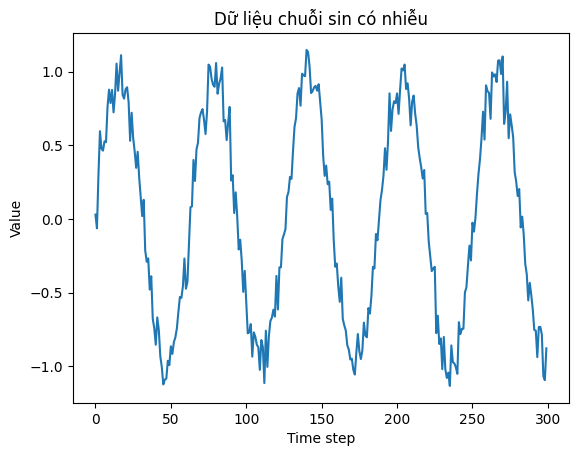

In [ ]:
# Tạo dữ liệu sin với noise
def generate_data(seq_length=1000):
    t = np.linspace(0, 100, seq_length)
    y = np.sin(t) + 0.1 * np.random.randn(seq_length)  # sin + noise
    return y

# Dữ liệu
data = generate_data()
plt.plot(data[:300])
plt.title("Dữ liệu chuỗi sin có nhiễu")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.show()


Xây dựng mô hình RNN đơn giản

In [ ]:
# Mô hình RNN đơn giản
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=20):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        out = self.fc(out)
        return out, h

Hàm training với tùy chọn Randomized Truncation

In [ ]:
# Hàm training có đo thời gian và bộ nhớ
def train(model, data, use_randomized_truncation=False, pi=0.9, num_epochs=30, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    model.train()

    # Đo thời gian bắt đầu
    start_time = time.time()

    # Đo bộ nhớ ban đầu
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024  # MB

    # Đo bộ nhớ GPU ban đầu
    if torch.cuda.is_available():
        gpu_mem_before = torch.cuda.memory_allocated() / 1024 ** 2  # MB
        gpu_reserved_before = torch.cuda.memory_reserved() / 1024 ** 2  # MB
    else:
        gpu_mem_before = 0.0
        gpu_reserved_before = 0.0

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        h = None
        loss_epoch = 0
        count = 0

        for t in range(len(data)-1):
            x = torch.tensor([[data[t]]], dtype=torch.float32).unsqueeze(0).to(device)  # (batch, seq_len, input_size)
            y_true = torch.tensor([[data[t+1]]], dtype=torch.float32).unsqueeze(0).to(device)

            y_pred, h = model(x, h)

            loss = criterion(y_pred, y_true)
            loss_epoch += loss

            # Randomized truncation
            if use_randomized_truncation:
                if np.random.rand() > pi:
                    h = h.detach()

            count += 1

        loss_epoch = loss_epoch / count
        loss_epoch.backward()
        optimizer.step()
        losses.append(loss_epoch.item())

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_epoch.item():.6f}")

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Đo bộ nhớ GPU sau huấn luyện
    if torch.cuda.is_available():
        gpu_mem_after = torch.cuda.memory_allocated() / 1024 ** 2  # MB
        gpu_reserved_after = torch.cuda.memory_reserved() / 1024 ** 2  # MB
    else:
        gpu_mem_after = 0.0
        gpu_reserved_after = 0.0

    # Tính bộ nhớ GPU sử dụng
    gpu_mem_used = gpu_mem_after - gpu_mem_before
    gpu_reserved_used = gpu_reserved_after - gpu_reserved_before

    # Đo bộ nhớ sau huấn luyện
    mem_after = process.memory_info().rss / 1024 / 1024  # MB
    mem_used = mem_after - mem_before

    return losses, elapsed_time, mem_used, gpu_mem_used, gpu_reserved_used


Giải thích:


*   Với use_randomized_truncation=True, tại mỗi bước $t$, xác suất $1-\pi_t$ sẽ cắt đứt backpropagation (bằng .detach()).
*   Nếu không, để gradient lan truyền bình thường.
*   Cuối mỗi epoch, tính Loss trung bình và lưu lại để vẽ biểu đồ.



Huấn luyện mô hình và so sánh

Training WITHOUT Randomized Truncation...
Epoch 5/30, Loss: 0.291249
Epoch 10/30, Loss: 0.088216
Epoch 15/30, Loss: 0.032045
Epoch 20/30, Loss: 0.026142
Epoch 25/30, Loss: 0.025257
Epoch 30/30, Loss: 0.020180

Training WITH Randomized Truncation (pi=0.9)...
Epoch 5/30, Loss: 0.225303
Epoch 10/30, Loss: 0.067189
Epoch 15/30, Loss: 0.042826
Epoch 20/30, Loss: 0.029310
Epoch 25/30, Loss: 0.023431
Epoch 30/30, Loss: 0.021291


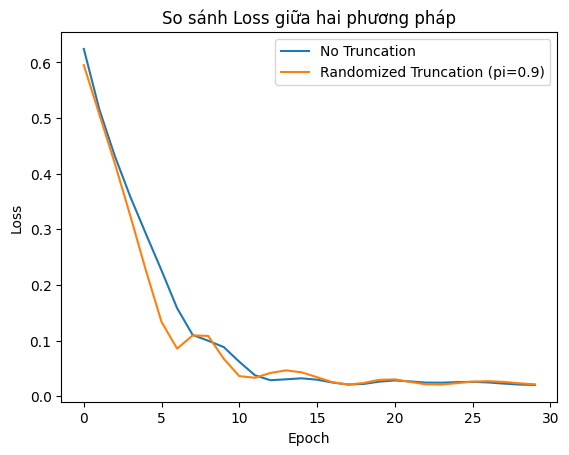


==== Tổng Kết ====
[No Truncation]    Thời gian: 23.60 giây, Bộ nhớ tăng (CPU): 0.36 MB
[Random Truncation] Thời gian: 18.39 giây, Bộ nhớ tăng (CPU): -8.97 MB


In [13]:
# --- Chạy và so sánh ---
data = generate_data()

# Huấn luyện model không truncate
print("Training WITHOUT Randomized Truncation...")
model_standard = SimpleRNN().to(device)
losses_standard, time_standard, memory_standard, gpu_mem_standard, gpu_reserved_standard = train(model_standard, data, use_randomized_truncation=False)

# Huấn luyện model có truncate
print("\nTraining WITH Randomized Truncation (pi=0.9)...")
model_truncated = SimpleRNN().to(device)
losses_truncated, time_truncated, memory_truncated, gpu_mem_truncated, gpu_reserved_truncated = train(model_truncated, data, use_randomized_truncation=True, pi=0.9)

# Vẽ biểu đồ Loss
plt.plot(losses_standard, label="No Truncation")
plt.plot(losses_truncated, label="Randomized Truncation (pi=0.9)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("So sánh Loss giữa hai phương pháp")
plt.show()

# In kết quả tổng hợp
print("\n==== Tổng Kết ====")
print(f"[No Truncation]    Thời gian: {time_standard:.2f} giây, Bộ nhớ tăng (CPU): {memory_standard:.2f} MB")
print(f"[Random Truncation] Thời gian: {time_truncated:.2f} giây, Bộ nhớ tăng (CPU): {memory_truncated:.2f} MB")

# In bộ nhớ GPU tổng thể kèm theo thời gian huấn luyện
if torch.cuda.is_available():
    print("\n==== Thống kê GPU (kèm thời gian huấn luyện) ====")
    print(f"[No Truncation]    Thời gian: {time_standard:.2f} giây | Bộ nhớ GPU sử dụng: {gpu_mem_standard:.2f} MB | Bộ nhớ GPU reserved: {gpu_reserved_standard:.2f} MB")
    print(f"[Random Truncation] Thời gian: {time_truncated:.2f} giây | Bộ nhớ GPU sử dụng: {gpu_mem_truncated:.2f} MB | Bộ nhớ GPU reserved: {gpu_reserved_truncated:.2f} MB")

Giải thích kết quả

*   **Loss không truncate:** thường thấp hơn một chút, do sử dụng toàn bộ thông tin quá khứ.
*   **Loss Randomized Truncation:** có thể dao động hơn, nhưng lại giúp:
  *   Tiết kiệm bộ nhớ.
  *   Training nhanh hơn.
  *   Tránh vanishing gradient trong chuỗi quá dài.





In [14]:
# Dự đoán giá trị tiếp theo
model_truncated.eval()  # Chuyển mô hình sang chế độ đánh giá
with torch.no_grad():  # Tắt gradient khi dự đoán
    x_input = torch.tensor([[data[-1]]], dtype=torch.float32).unsqueeze(0).to(device)  # Dữ liệu đầu vào
    y_pred, _ = model_truncated(x_input, h=None)  # Dự đoán giá trị tiếp theo
    print(f"Dự đoán giá trị tiếp theo: {y_pred.item():.6f}")

Dự đoán giá trị tiếp theo: -0.309256
